  Group  Mean        SD
0     A   3.0  1.581139
1     B   3.0  1.581139
2     C   3.0  1.581139
3     D   3.0  1.581139
ANOVA result: F_onewayResult(statistic=0.0, pvalue=1.0)

ANOVA table:
                 sum_sq    df             F  PR(>F)
Group     1.140151e-30   3.0  1.520201e-31     1.0
Residual  4.000000e+01  16.0           NaN     NaN
[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
[6.0, 6.0, 6.0, 6.0, 6.0, 6.0]


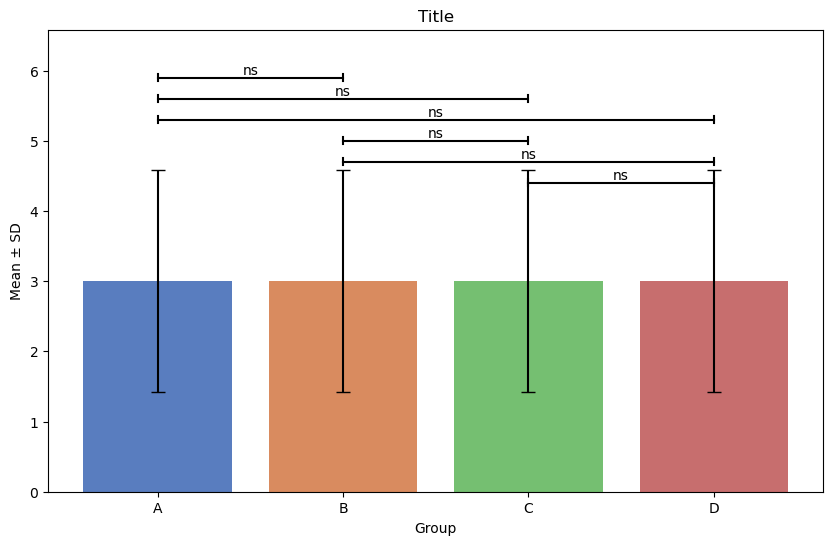

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Define the data
A = [1, 2, 3, 4, 5]
B = [1, 2, 3, 4, 5]
C = [1, 2, 3, 4, 5]
D = [1, 2, 3, 4, 5]

# Create a DataFrame
data = pd.DataFrame({
    'Group': np.repeat(['A', 'B', 'C', 'D'], 5),
    'Value': DMSO + FADS1 + FADS2 + FADS12})

# Reorder the levels of Group factor
data['Group'] = pd.Categorical(data['Group'], categories=['A', 'B', 'C', 'D'], ordered=True)

# Calculate means and standard deviations
summary_stats = data.groupby('Group').agg(Mean=('Value', 'mean'), SD=('Value', 'std')).reset_index()
print(summary_stats)

# Perform one-way ANOVA
anova_result = stats.f_oneway(DMSO, FADS1, FADS2, FADS12)
print('ANOVA result:', anova_result)

# Display detailed ANOVA results using statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA using statsmodels
model = ols('Value ~ Group', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('\nANOVA table:\n', anova_table)

# Perform pairwise t-tests with Bonferroni correction
group_combinations = list(combinations(['A', 'B', 'C', 'D'], 2))
p_values = []
for (group1, group2) in group_combinations:
    group1_values = data[data['Group'] == group1]['Value']
    group2_values = data[data['Group'] == group2]['Value']
    t_stat, p_val = stats.ttest_ind(group1_values, group2_values)
    p_values.append(p_val)
print(group_combinations)

# Apply Bonferroni correction
bonferroni_corrected_p = [p * len(p_values) for p in p_values]
significance_labels = ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns' for p in bonferroni_corrected_p]
print(bonferroni_corrected_p)

# Create a DataFrame for pairwise comparisons
pairwise_results = pd.DataFrame(group_combinations, columns=['group1', 'group2'])
pairwise_results['p-adj'] = bonferroni_corrected_p
pairwise_results['Signif'] = significance_labels

# Determine y position for annotations with incremental y-values
def position_signif(data, group1, group2, increment, index):
    max_y = max(data[data['Group'].isin([group1, group2])]['Mean'])
    return max_y + 2.9 - index * increment

# Initialize the increment and index for y-position
increment = 0.3
pairwise_results['y_position'] = pairwise_results.apply(lambda row: position_signif(summary_stats, row['group1'], row['group2'], increment, row.name), axis=1)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Group', y='Mean', data=summary_stats, ci=None, palette='muted')
plt.errorbar(x=summary_stats['Group'].cat.codes, y=summary_stats['Mean'], yerr=summary_stats['SD'], fmt='none', capsize=5, color='black')




# Add significance brackets
def draw_bracket(ax, x_start, x_end, y_pos):
    bracket_height = 0.05
    bracket_width = x_end - x_start
   
    ax.plot([x_start, x_start], [y_pos - bracket_height, y_pos + bracket_height], color='black')
    ax.plot([x_end, x_end], [y_pos - bracket_height, y_pos + bracket_height], color='black')
    ax.plot([x_start, x_end], [y_pos, y_pos], color='black')

# Plot the brackets and annotations
for _, row in pairwise_results.iterrows():
    group1 = row['group1']
    group2 = row['group2']
    y = row['y_position']
    
    x1 = summary_stats[summary_stats['Group'] == group1].index[0]
    x2 = summary_stats[summary_stats['Group'] == group2].index[0]
    
# Convert x indices to actual x positions
    x_start = x1
    x_end = x2
    
# Draw the bracket
    draw_bracket(plt.gca(), x_start, x_end, y)
    
# Calculate the mid-point for the annotation
    x_mid = (x1 + x2) / 2
    plt.text(x_mid, y, row['Signif'], ha='center', va='bottom')
    
plt.title('Title')
plt.xlabel('Group')
plt.ylabel('Mean ± SD')
plt.ylim(0, max(summary_stats['Mean'] + summary_stats['SD']) + 2)
plt.xticks(ticks=range(len(summary_stats['Group'])), labels=summary_stats['Group'])
plt.show()